# 解析输入

使用文法可以生成相应语言的字符串。反过来，给定字符串，可以将该字符串分解为语法树的组成部分(这些组成部分对应于用于生成该字符串的派生树的语法部分)。
本章，会通过语法分析，将有效的种子输入，分解&解析成对应的语法树组成部分。这允许我们变异、交叉和重新组合它们的部分，以便生成新的有效的、稍加更改的输入(即fuzz)。

In [ ]:
# 导入内容
from fuzzingbook.fuzzingbook_utils.Grammars import EXPR_GRAMMAR, START_SYMBOL, RE_NONTERMINAL, is_valid_grammar
from fuzzingbook.fuzzingbook_utils.GrammarFuzzer import GrammarFuzzer, display_tree, tree_to_string, dot_escape
import string

## 被测试程序

In [ ]:
def process_inventory(inventory):
    res = []
    for vehicle in inventory.split('\n'):
        ret = process_vehicle(vehicle)
        res.extend(ret)
    return '\n'.join(res)

def process_vehicle(vehicle):
    year, kind, company, model, *_ = vehicle.split(',')
    if kind == 'van':
        return process_van(year, company, model)

    elif kind == 'car':
        return process_car(year, company, model)

    else:
        raise Exception('Invalid entry')

def process_van(year, company, model):
    res = ["We have a %s %s van from %s vintage." % (company, model, year)]
    iyear = int(year)
    if iyear > 2010:
        res.append("It is a recent model!")
    else:
        res.append("It is an old but reliable model!")
    return res

def process_car(year, company, model):
    res = ["We have a %s %s car from %s vintage." % (company, model, year)]
    iyear = int(year)
    if iyear > 2016:
        res.append("It is a recent model!")
    else:
        res.append("It is an old but reliable model!")
    return res

In [ ]:
# 我们需要测试process_inventory函数

mystring = """\
1997,van,Ford,E350
2000,car,Mercury,Cougar\
"""
print(process_inventory(mystring))

## 测试程序而创建的文法

下面的文法定义的很宽泛。有效的测试输入，是这个文法生成语言的子集。

宽泛，导致很难生成正确的输入，导致测试相当低效。

方案一：我们可以修改下文法，在文法中，将"van","car"作为其中可能的终结符。

方案二：修改GrammarFuzzer中扩展节点的函数，加入一个存储"van","car"的扩展可能，使得有一定几率使用这些特定的值。

方案三： In fact, it would be nice if we could extract the template and valid values from samples, and use them in our fuzzing. How do we do that? The quick answer to this question is: Use a parser.
【事实上，如果我们能从样本中提取模板和有效值，并在我们的模糊中使用它们，那就太好了。我们怎么做呢?对这个问题的快速回答是:使用解析器。】


In [ ]:
CSV_GRAMMAR = {
    '<start>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

In [ ]:
gf = GrammarFuzzer(CSV_GRAMMAR, min_nonterminals=4,log=False)
gf.fuzz()

## 一个特定的解析器

In [43]:
# 以为某一行内部元素可能包含字符串，比如下面这个
# mystring = '''\
# 1997,Ford,E350,"ac, abs, moon",3000.00\
# '''
# 所以以逗号作为分割。如果从左到由分割的时候，遇见了引号，引号内部为一整体。非引号内部任然使用逗号分割。
# 其中的整体是这种结构： "*",但是引号里面不要加引号了，处理不了，比如下面这个
# mystring = '''\
# 1999,Chevy,"Venture \\"Extended Edition, Very Large\\"",,5000.00\
# '''
# 丫的，我没想出来这个”解决办法“，看书中的代码才明白

def parse_quote(string, i):
    v = string[i + 1:].find('"')
    return v + i + 1 if v >= 0 else -1

def find_comma(string, i):
    slen = len(string)
    while i < slen:
        if string[i] == '"':
            i = parse_quote(string, i)
            if i == -1:
                return -1
        if string[i] == ',':
            return i
        i += 1
    return -1

def comma_split(string):
    slen = len(string)
    i = 0
    while i < slen:
        c = find_comma(string, i)
        if c == -1:
            yield string[i:]
            return
        else:
            yield string[i:c]
        i = c + 1

def parse_csv(mystring):
    children = []
    tree = (START_SYMBOL, children)
    for i, line in enumerate(mystring.split('\n')):
        children.append(("record %d" % i, [(cell, [])
                                           for cell in comma_split(line)]))
    return tree

In [44]:
def lr_graph(dot):
    dot.attr('node', shape='plain')
    dot.graph_attr['rankdir'] = 'LR'

In [45]:
def highlight_node(predicate):
    # 这个函数很漂亮。node_atrr的函数，需要四个参数。
    def hl_node(dot, nid, symbol, ann):
        if predicate(dot, nid, symbol, ann):
            dot.node(repr(nid), dot_escape(symbol), fontcolor='red')
        else:
            dot.node(repr(nid), dot_escape(symbol))
    return hl_node

# 这里人为认为是错误节点的序号；错误的节点，高亮显示
bad_nodes = {5, 6, 7} 
def hl_predicate(_d, nid, _s, _a): return nid in bad_nodes
highlight_err_node = highlight_node(hl_predicate)

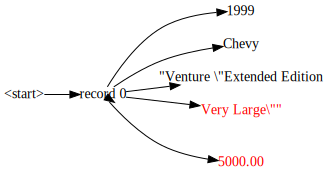

In [47]:
mystring = '''\
1997,Ford,E350,"ac, abs, moon",3000.00\
'''
tree = parse_csv(mystring)
display_tree(tree, log=False, node_attr=highlight_err_node,
             graph_attr=lr_graph)

# 暂时跳过本章；暂时不关系内部如何实现，从字符串倒推语法树的实现。